In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

nb_years = 12
yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
from_date = (datetime.today() - timedelta(days=365*nb_years)).strftime('%Y-%m-%d')

file_path = f"../dataset/CAC40_closing_prices_{from_date}_to_{yesterday}.csv"
print(f"Loading data from {file_path}")
data = pd.read_csv(file_path)
data.drop(columns=['Date'], inplace=True)
validation_days = 5   # Nombre de jours de validation

# Data preprocessing
stock_name = 'EN.PA'  # Remplacez par le nom du stock souhaité
if stock_name in data.columns:  # Vérifiez que la colonne existe
    stock_data = data[stock_name]
data_minus_validation = stock_data[:-validation_days]
data_minus_validation

Loading data from ../dataset/CAC40_closing_prices_2013-03-30_to_2025-03-26.csv


0       11.736626
1       11.270609
2       11.243672
3       11.087434
4       11.122453
          ...    
3060    35.320000
3061    35.799999
3062    36.049999
3063    36.279999
3064    36.320000
Name: EN.PA, Length: 3065, dtype: float64

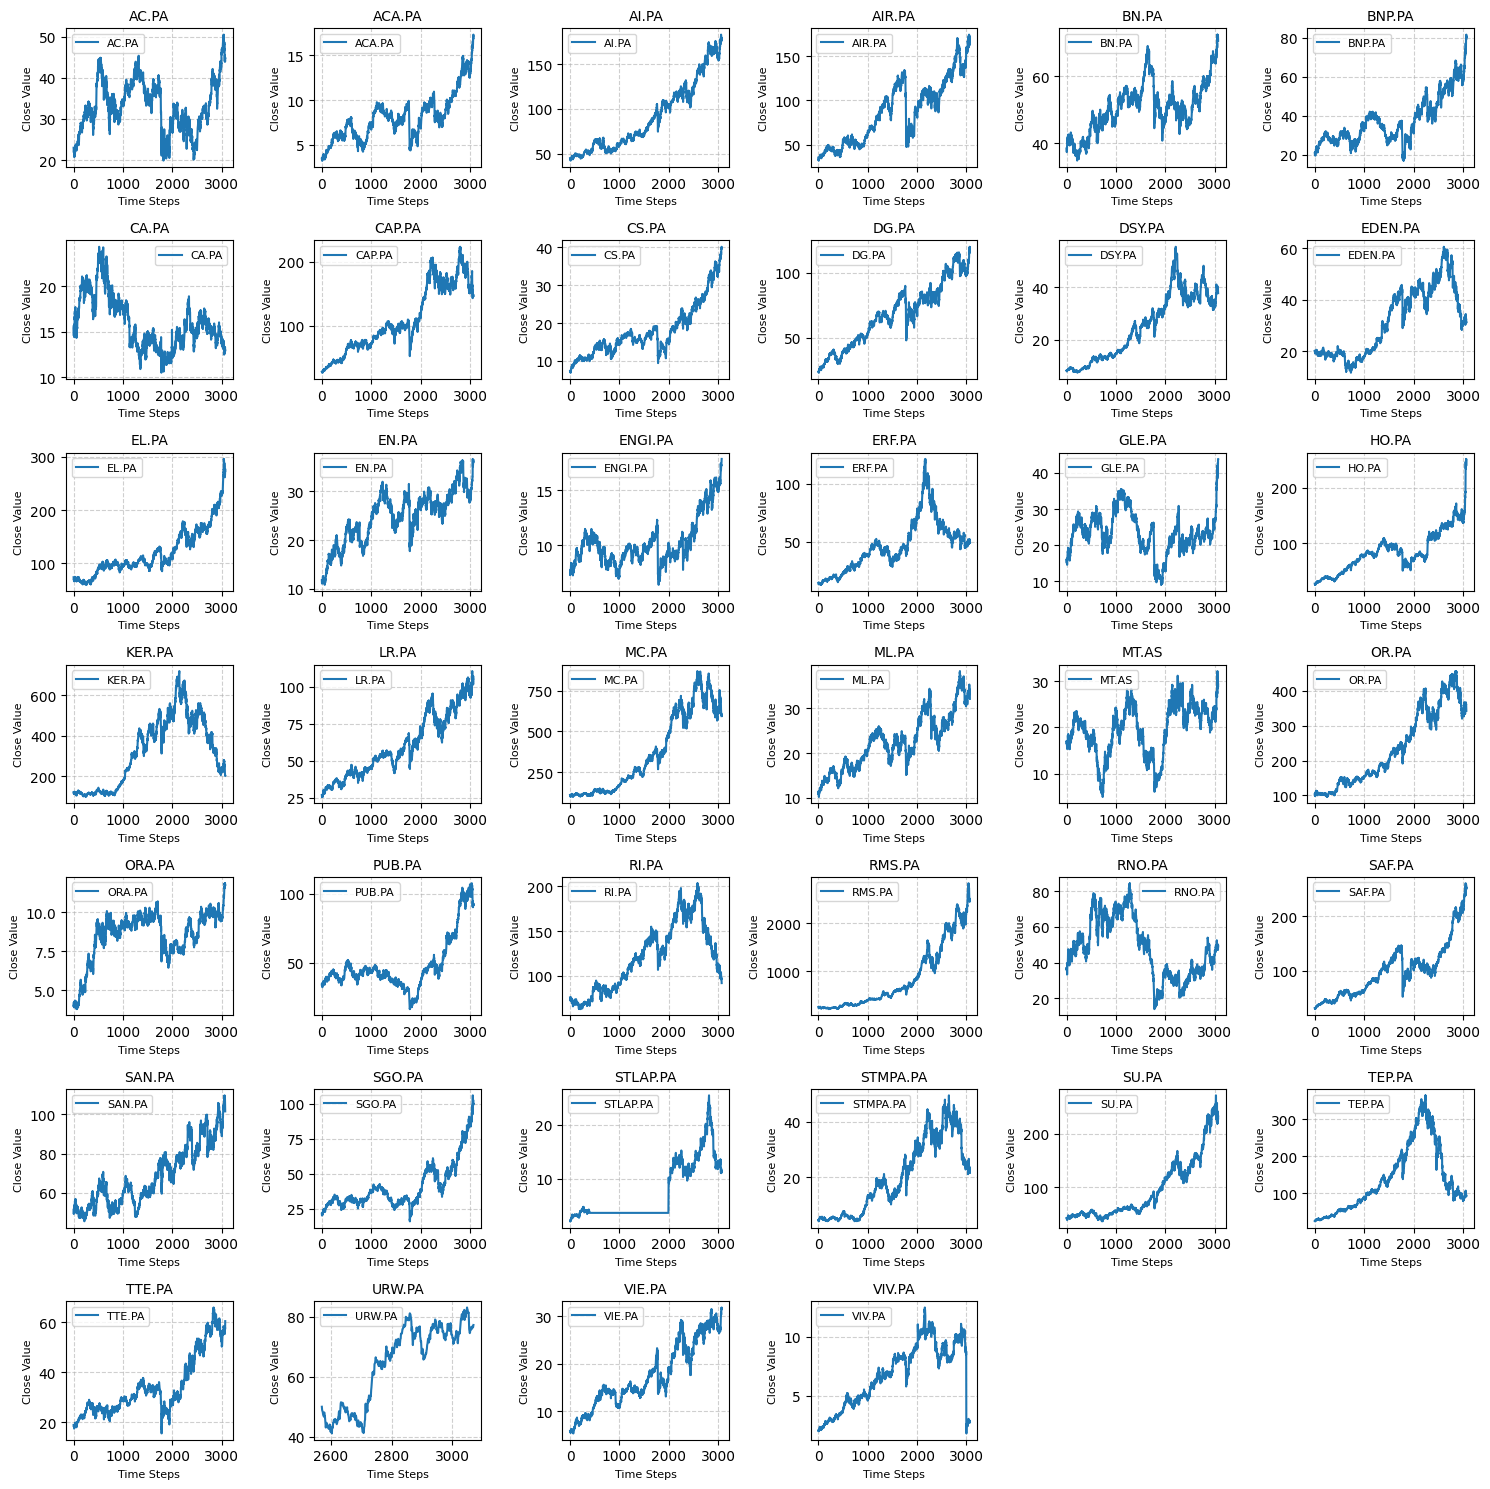

In [133]:
plt.figure(figsize=(15, 15))
num_stocks = len(data.columns)

# Calculate grid size
rows = int(np.ceil(np.sqrt(num_stocks)))
cols = int(np.ceil(num_stocks / rows))

for i, stock_name_display in enumerate(data.columns, 1):
    plt.subplot(rows, cols, i)
    plt.plot(data[stock_name_display].values, label=stock_name_display)
    plt.title(stock_name_display, fontsize=10)
    plt.xlabel("Time Steps", fontsize=8)
    plt.ylabel("Close Value", fontsize=8)
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

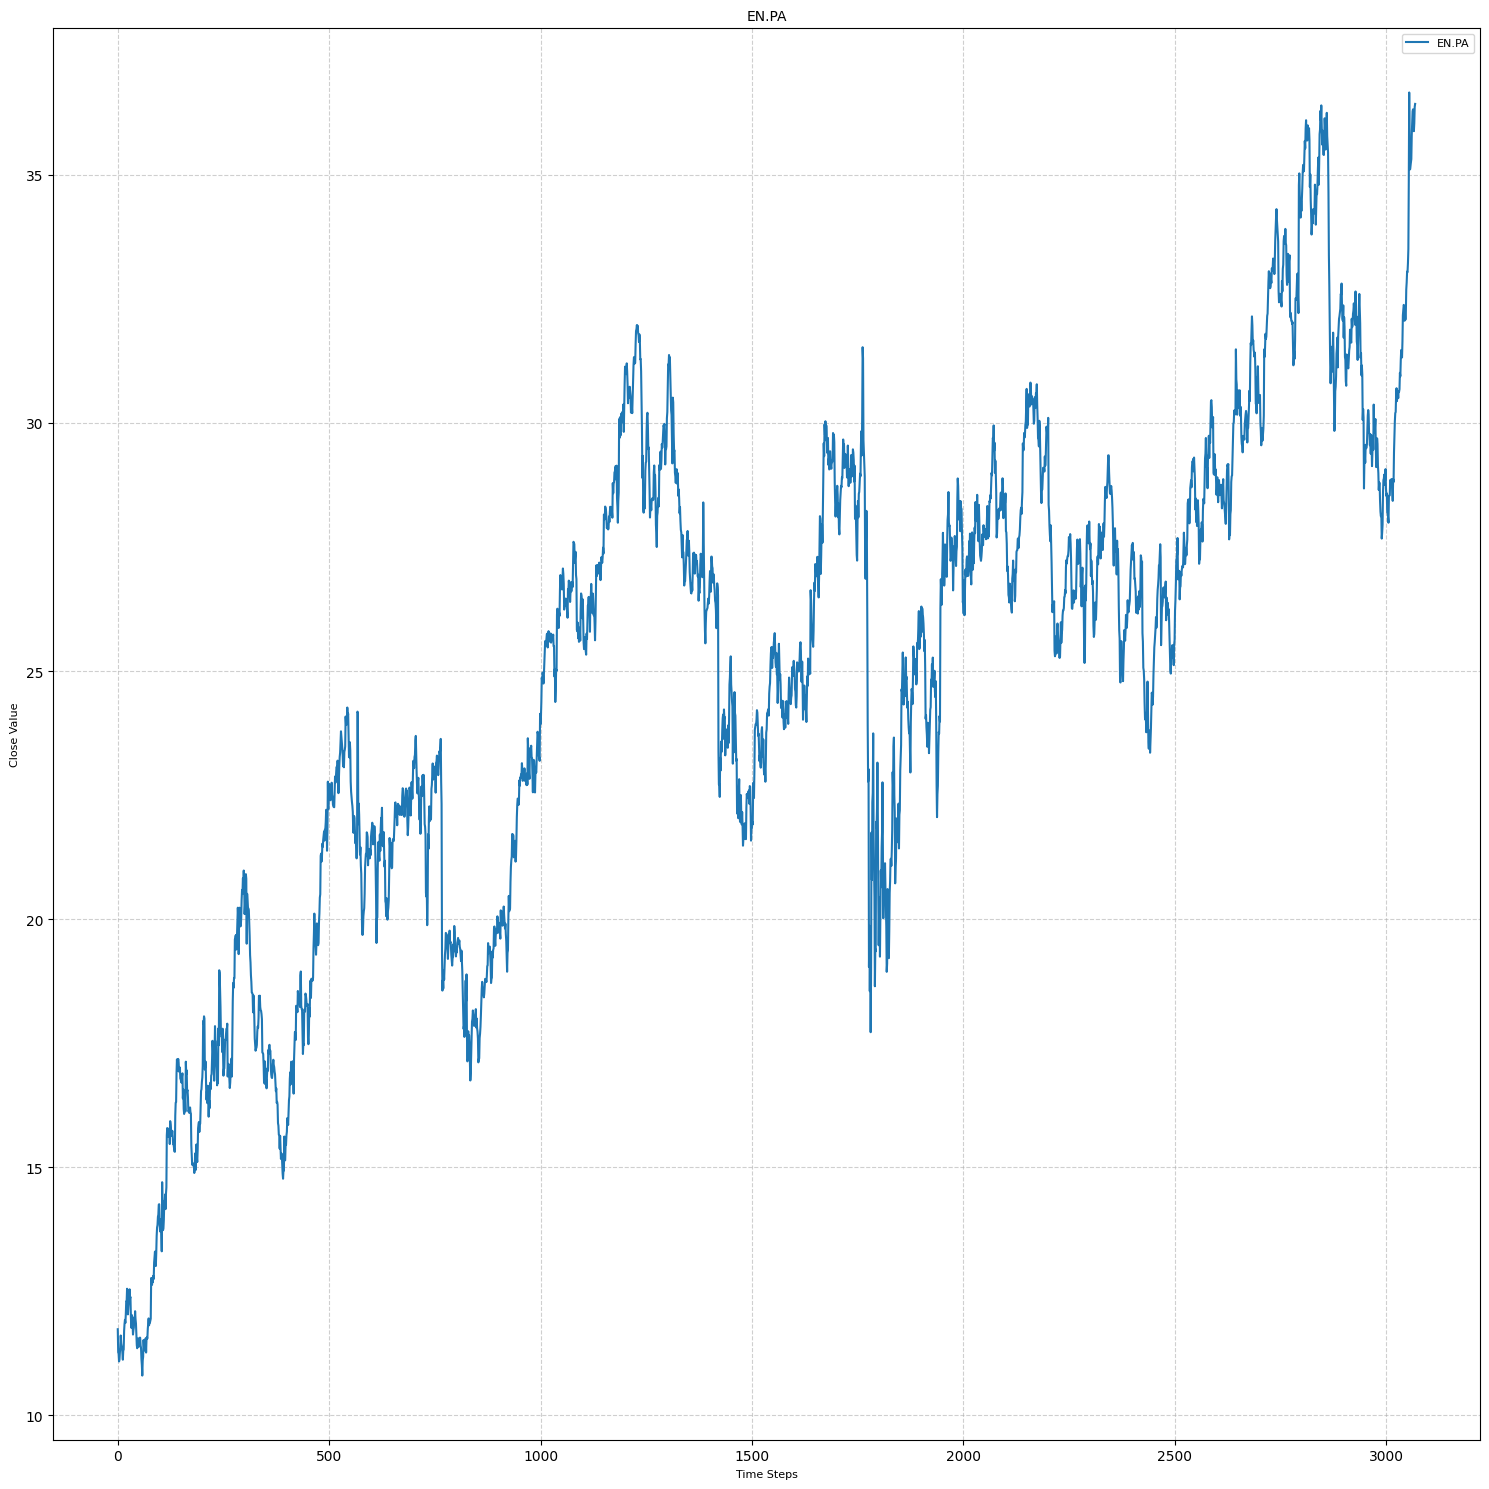

In [134]:
plt.figure(figsize=(15, 15))


plt.plot(stock_data.values, label=stock_name)
plt.title(stock_name, fontsize=10)
plt.xlabel("Time Steps", fontsize=8)
plt.ylabel("Close Value", fontsize=8)
plt.legend(fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [135]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

In [136]:
scaled_data = scaler.fit_transform(data_minus_validation.values.reshape(-1, 1))
scaled_data

array([[0.03612002],
       [0.01809741],
       [0.01705567],
       ...,
       [0.976409  ],
       [0.98530394],
       [0.98685092]])

In [137]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [201]:
time_step = 100
X, y = create_dataset(scaled_data, time_step)
X[0], y[0]

(array([0.03612002, 0.01809741, 0.01705567, 0.01101334, 0.01236765,
        0.01809741, 0.02163942, 0.03122369, 0.02518147, 0.0228895 ,
        0.02247281, 0.01799325, 0.01236765, 0.01976426, 0.02018092,
        0.03486986, 0.04028707, 0.04341232, 0.04101634, 0.04757948,
        0.05779115, 0.05767889, 0.06766609, 0.06474842, 0.04769164,
        0.05375131, 0.05812778, 0.05902549, 0.06721735, 0.06025979,
        0.06126977, 0.04600841, 0.03725565, 0.04724293, 0.04320308,
        0.04006095, 0.03198151, 0.03546016, 0.03736781, 0.04544736,
        0.04151982, 0.05016042, 0.04398853, 0.04062211, 0.03243036,
        0.02367753, 0.02132105, 0.02648289, 0.02895175, 0.02502406,
        0.02255543, 0.02468751, 0.02951276, 0.02951276, 0.0234531 ,
        0.02165768, 0.01279257, 0.00807959, 0.        , 0.01167043,
        0.01458803, 0.0277173 , 0.02233096, 0.02334087, 0.02233096,
        0.01918886, 0.02906387, 0.01795452, 0.02839059, 0.02984939,
        0.02883937, 0.0364701 , 0.04062211, 0.04

In [139]:
train_size = int(len(X) * 0.6)  # 60% for training
val_size = int(len(X) * 0.2)    # 20% for validation and keep 20% for testing

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (1778, 100) (1778,)
Validation data shape: (592, 100) (592,)
Test data shape: (594, 100) (594,)


Finding best hyperparameters

In [ ]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, LSTM

def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units
    lstm_units = hp.Int('lstm_units', min_value=128, max_value=256, step=32)
    dense_units = hp.Int('dense_units', min_value=64, max_value=128, step=32)
    activation_function = hp.Choice('activation_function', values=['tanh']) # Remove the 'relu' option because never used

    model.add(LSTM(units=lstm_units, activation=activation_function, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=lstm_units, activation=activation_function))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Use Keras Tuner to find the best hyperparameters
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='tuner_results',
    project_name=f'stock_prediction_{stock_name}'
)

# Perform the search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Trial 30 Complete [00h 00m 58s]
val_loss: 0.0003419012646190822

Best val_loss So Far: 0.0002274030412081629
Total elapsed time: 00h 19m 02s
Best Hyperparameters: {'lstm_units': 128, 'dense_units': 64, 'activation_function': 'tanh', 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,465 (806.50 KB)

 Trainable params: 206,465 (806.50 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveille la perte sur l'ensemble de validation
    patience=10,         # Arrête après 10 epochs sans amélioration
    restore_best_weights=True  # Restaure les poids du meilleur modèle
)

history = best_model.fit(
    X_train, y_train,
    epochs=100,  # Nombre maximum d'epochs
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0398 - mae: 0.1290 - val_loss: 0.0013 - val_mae: 0.0298
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0013 - mae: 0.0254 - val_loss: 0.0012 - val_mae: 0.0281
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0013 - mae: 0.0265 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0012 - mae: 0.0241 - val_loss: 0.0013 - val_mae: 0.0274
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011 - mae: 0.0233 - val_loss: 8.8533e-04 - val_mae: 0.0228
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011 - mae: 0.0228 - val_loss: 9.5228e-04 - val_mae: 0.0230
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.6843e-04 - mae: 0.0222 - val_loss: 7.5842e-04 - val_mae: 0.0217
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 9.1597e-04 - mae: 0.0215 - val_loss: 8.9697e-04 - val_mae: 0.0245
Epoch 9/100
56/56 ━━━━━━━━━━━━━━

In [209]:
test_loss = best_model.evaluate(X_test, y_test)
test_loss

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.7245e-04 - mae: 0.0098


[0.00020032530301250517, 0.010336634702980518]

In [210]:
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [211]:
original_data = data_minus_validation.values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions):] = predictions.reshape(-1)

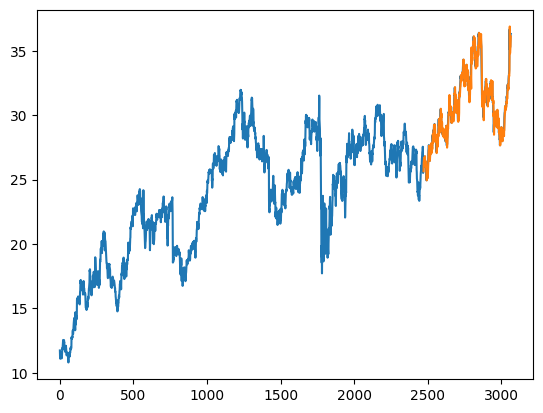

In [212]:
plt.plot(original_data)
plt.plot(predicted_data)

In [213]:
new_predictions = best_model.predict(X_test[-validation_days:])
new_predictions = scaler.inverse_transform(new_predictions)
predicted_data = np.append(predicted_data, new_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


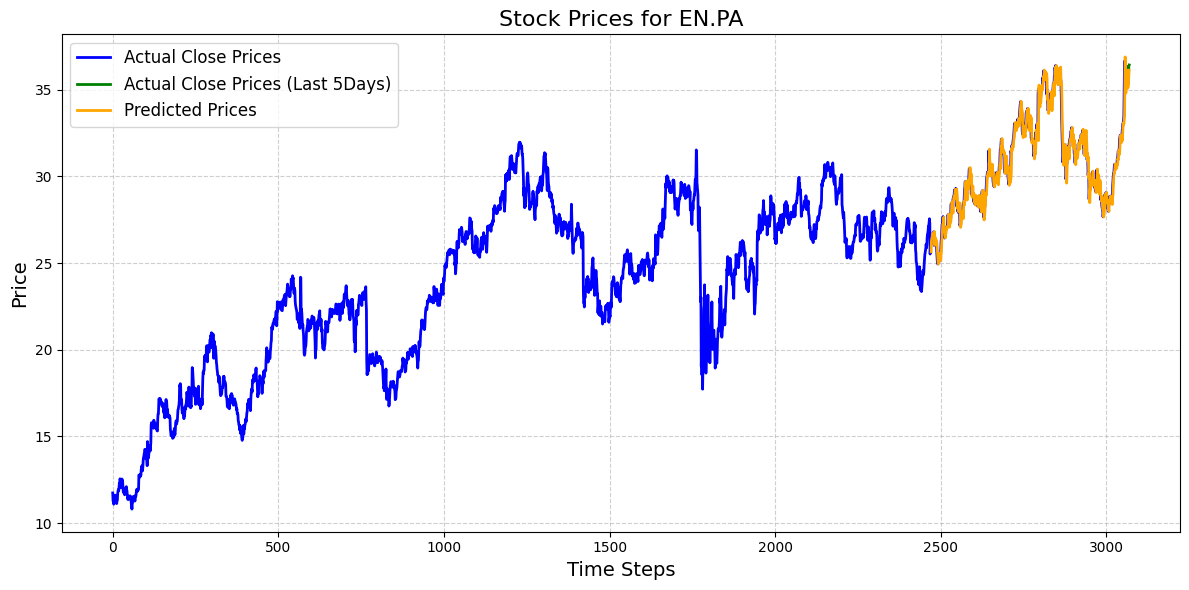

In [214]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the entire Actual Close Prices in blue
plt.plot(data_minus_validation.values, label='Actual Close Prices', color='blue', linewidth=2)

# Highlight the last validation_days of Actual Close Prices in green
plt.plot(range(len(stock_data) - validation_days, len(stock_data)), stock_data.values[-validation_days:], color='green', linewidth=2, label=f'Actual Close Prices (Last {validation_days}Days)')

# Plot the Predicted Prices in orange
plt.plot(predicted_data, label='Predicted Prices', color='orange', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.title(f"Stock Prices for {stock_name}", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

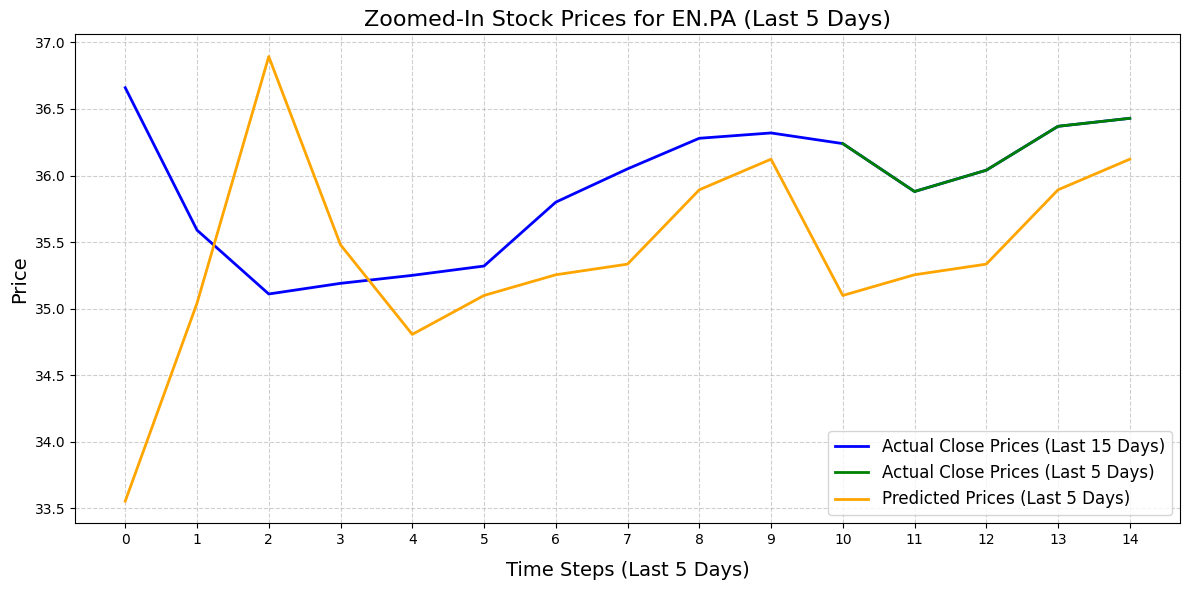

In [215]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the last (validation_days + 10) days of Actual Close Prices in blue
plt.plot(stock_data.values[-(validation_days + 10):], label=f'Actual Close Prices (Last {validation_days + 10} Days)', color='blue', linewidth=2)

# Plot the last validation_days of Actual Close Prices in green, starting after 10 days
plt.plot(range(10, 10 + validation_days), stock_data.values[-validation_days:], label=f'Actual Close Prices (Last {validation_days} Days)', color='green', linewidth=2)

# Plot the last validation_days of Predicted Prices in orange, starting after 10 days
plt.plot(range(0, 10 + validation_days), predicted_data[-(validation_days+10):], label=f'Predicted Prices (Last {validation_days} Days)', color='orange', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.title(f"Zoomed-In Stock Prices for {stock_name} (Last {validation_days} Days)", fontsize=16)
plt.xlabel(f"Time Steps (Last {validation_days} Days)", fontsize=14, labelpad=10)
plt.ylabel("Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid for better readability

# Force x-axis step to 1
x_ticks = range(0, validation_days + 10)  # Generate ticks from 0 to (validation_days + 10)
plt.xticks(ticks=x_ticks)

plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [216]:
# Parameters
initial_money = 100  # Initial virtual money
threshold = 0.01  # Threshold for buying/selling (1%)

# Initialize variables
money = initial_money
stocks_owned = 0
money_over_time = []  # To track the evolution of money over time

# Limit the simulation to 365 days
months = 12
days_to_simulate = months*30
limited_predictions = predictions[:days_to_simulate]

# Iterate through predictions
for i in range(len(limited_predictions) - 1):
    current_predicted_price = limited_predictions[i][0]
    next_predicted_price = limited_predictions[i + 1][0]
    actual_price = stock_data.iloc[len(stock_data) - len(predictions) + i]  # Actual price for the current day

    # Buy condition
    if next_predicted_price > current_predicted_price * (1 + threshold):
        # Buy stocks with all available money
        initial_money_current = money
        stocks_to_buy = money // actual_price
        money -= stocks_to_buy * actual_price
        stocks_owned += stocks_to_buy
        print(f"Buying:\n\tinitial_money: {initial_money_current}€\n\tfinal_money: {money}€\n\tactual_price: {actual_price}€\n\tnb_bought: {stocks_to_buy}")

    # Sell condition
    elif next_predicted_price < current_predicted_price * (1 - threshold):
        # Sell all owned stocks
        initial_money_current = money
        money += stocks_owned * actual_price
        print(f"Selling:\n\tinitial_money: {initial_money_current}€\n\tfinal_money: {money}€\n\tactual_price: {actual_price}€\n\tnb_sold: {stocks_owned}")
        stocks_owned = 0

    # Track money over time
    money_over_time.append(money + stocks_owned * actual_price)

# Final value of portfolio
final_value = money + stocks_owned * stock_data.iloc[-1]

print(f"Initial money: {initial_money}")
print(f"Final portfolio value after {days_to_simulate} days: {final_value}")

Buying:
	initial_money: 100€
	final_money: 20.12641334533693€
	actual_price: 26.62452888488769€
	nb_bought: 3.0
Selling:
	initial_money: 20.12641334533693€
	final_money: 98.87123489379884€
	actual_price: 26.248273849487305€
	nb_sold: 3.0
Buying:
	initial_money: 98.87123489379884€
	final_money: 20.85204887390138€
	actual_price: 26.00639533996582€
	nb_bought: 3.0
Selling:
	initial_money: 20.85204887390138€
	final_money: 96.80183410644533€
	actual_price: 25.31659507751465€
	nb_sold: 3.0
Selling:
	initial_money: 96.80183410644533€
	final_money: 96.80183410644533€
	actual_price: 25.51367950439453€
	nb_sold: 0
Selling:
	initial_money: 96.80183410644533€
	final_money: 96.80183410644533€
	actual_price: 25.52263832092285€
	nb_sold: 0
Selling:
	initial_money: 96.80183410644533€
	final_money: 96.80183410644533€
	actual_price: 25.26284408569336€
	nb_sold: 0
Buying:
	initial_money: 96.80183410644533€
	final_money: 21.44330787658693€
	actual_price: 25.119508743286133€
	nb_bought: 3.0
Selling:
	initi

In [217]:
# Parameters
initial_money = 1000  # Initial virtual money
threshold = 0.01  # Threshold for buying/selling (1%)
target_profit = 0.05  # Target profit (5%)
stop_loss = 0.10  # Stop-loss (10%)

# Initialize variables
money = initial_money
stocks_owned = 0
buying_price = None  # Track the buying price for stop-loss and target profit
money_over_time = []  # To track the evolution of money over time

# Limit the simulation to 365 days
months = 12
days_to_simulate = min(len(predictions), months * 30)
limited_predictions = predictions[:days_to_simulate]

# Iterate through predictions
for i in range(len(limited_predictions) - 1):
    current_predicted_price = limited_predictions[i][0]
    next_predicted_price = limited_predictions[i + 1][0]
    actual_price = stock_data.iloc[len(stock_data) - len(predictions) + i]  # Actual price for the current day

    # Buy condition
    if next_predicted_price > current_predicted_price * (1 + threshold) and stocks_owned == 0:
        # Buy stocks with all available money
        stocks_to_buy = money // actual_price
        money -= stocks_to_buy * actual_price
        stocks_owned += stocks_to_buy
        buying_price = actual_price  # Record the buying price
        print(f"Buying:\n\tMoney: {money}€\n\tActual Price: {actual_price}€\n\tStocks Bought: {stocks_to_buy}")

    # Sell condition: Target profit or stop-loss
    elif stocks_owned > 0:
        # Check target profit
        if actual_price >= buying_price * (1 + target_profit):
            money += stocks_owned * actual_price
            print(f"Selling (Target Profit):\n\tMoney: {money}€\n\tActual Price: {actual_price}€\n\tStocks Sold: {stocks_owned}")
            stocks_owned = 0
            buying_price = None  # Reset buying price

        # Check stop-loss
        elif actual_price <= buying_price * (1 - stop_loss):
            money += stocks_owned * actual_price
            print(f"Selling (Stop-Loss):\n\tMoney: {money}€\n\tActual Price: {actual_price}€\n\tStocks Sold: {stocks_owned}")
            stocks_owned = 0
            buying_price = None  # Reset buying price

    # Track money over time
    money_over_time.append(money + stocks_owned * actual_price)

# Final value of portfolio
final_value = money + stocks_owned * stock_data.iloc[-1]

print(f"Initial money: {initial_money}€")
print(f"Final portfolio value after {days_to_simulate} days: {final_value}€")

Buying:
	Money: 14.892431259155387€
	Actual Price: 26.62452888488769€
	Stocks Bought: 37.0
Selling (Target Profit):
	Money: 1064.9667263031006€
	Actual Price: 28.380386352539062€
	Stocks Sold: 37.0
Buying:
	Money: 12.57223892211914€
	Actual Price: 28.44309425354004€
	Stocks Bought: 37.0
Selling (Target Profit):
	Money: 1121.3604488372803€
	Actual Price: 29.967248916625977€
	Stocks Sold: 37.0
Buying:
	Money: 24.79231071472168€
	Actual Price: 30.46022605895996€
	Stocks Bought: 36.0
Selling (Target Profit):
	Money: 1182.110242843628€
	Actual Price: 32.14772033691406€
	Stocks Sold: 36.0
Buying:
	Money: 12.638597488403093€
	Actual Price: 31.607341766357425€
	Stocks Bought: 37.0
Selling (Target Profit):
	Money: 1245.2490863800047€
	Actual Price: 33.31379699707031€
	Stocks Sold: 37.0
Buying:
	Money: 24.213941574096452€
	Actual Price: 33.00094985961914€
	Stocks Bought: 37.0
Selling (Target Profit):
	Money: 1311.5447521209715€
	Actual Price: 34.792724609375€
	Stocks Sold: 37.0
Buying:
	Money: 1

In [218]:
# Parameters
initial_money = 100  # Initial virtual money
threshold = 0.01  # Threshold for buying/selling (1%)
target_profit = 0.05  # Target profit (5%)
stop_loss = 0.10  # Stop-loss (10%)

# Limit the simulation to 365 days
months = 12
days_to_simulate = min(len(predictions), months * 30)
limited_predictions = predictions[:days_to_simulate]

def simulate_strategy(threshold, target_profit, stop_loss):
    money = initial_money
    stocks_owned = 0
    buying_price = None  # Track the buying price for stop-loss and target profit
    money_over_time = []  # To track the evolution of money over time

    # Iterate through predictions
    for i in range(len(limited_predictions) - 1):
        current_predicted_price = limited_predictions[i][0]
        next_predicted_price = limited_predictions[i + 1][0]
        actual_price = stock_data.iloc[len(stock_data) - len(predictions) + i]  # Actual price for the current day

        # Buy condition
        if next_predicted_price > current_predicted_price * (1 + threshold) and stocks_owned == 0:
            # Buy stocks with all available money
            stocks_to_buy = money // actual_price
            money -= stocks_to_buy * actual_price
            stocks_owned += stocks_to_buy
            buying_price = actual_price  # Record the buying price
            #print(f"Buying:\n\tMoney: {money}€\n\tActual Price: {actual_price}€\n\tStocks Bought: {stocks_to_buy}")

        # Sell condition: Target profit or stop-loss
        elif stocks_owned > 0:
            # Check target profit
            if actual_price >= buying_price * (1 + target_profit):
                money += stocks_owned * actual_price
                #print(f"Selling (Target Profit):\n\tMoney: {money}€\n\tActual Price: {actual_price}€\n\tStocks Sold: {stocks_owned}")
                stocks_owned = 0
                buying_price = None  # Reset buying price

            # Check stop-loss
            elif actual_price <= buying_price * (1 - stop_loss):
                money += stocks_owned * actual_price
                #print(f"Selling (Stop-Loss):\n\tMoney: {money}€\n\tActual Price: {actual_price}€\n\tStocks Sold: {stocks_owned}")
                stocks_owned = 0
                buying_price = None  # Reset buying price

        # Track money over time
        money_over_time.append(money + stocks_owned * actual_price)

    # Final value of portfolio
    final_value = money + stocks_owned * stock_data.iloc[-1]

    print(f"\nConfig: Threshold={threshold}, Target Profit={target_profit}, Stop Loss={stop_loss}")
    print(f"Initial money: {initial_money}€")
    print(f"Final portfolio value after {days_to_simulate} days: {final_value}€\n")
    return final_value


thresholds = [i/10000 for i in range(0, 305, 5)]  # 0%, ..., 0.03%
target_profits = [i/100 for i in range(2, 11, 1)]  # 2%, ..., 10%
stop_losses = [i/100 for i in range(3, 21, 1)]  # 3%, ..., 20%

best_config = None
best_final_value = 0

for threshold in thresholds:
    for target_profit in target_profits:
        for stop_loss in stop_losses:
            # Simulate the strategy with the current configuration
            money, stocks_owned = initial_money, 0
            final_value = simulate_strategy(threshold, target_profit, stop_loss)  # Implement this function
            if final_value > best_final_value:
                best_final_value = final_value
                best_config = (threshold, target_profit, stop_loss)

print(f"Best Configuration: Threshold={best_config[0]}, Target Profit={best_config[1]}, Stop Loss={best_config[2]}\n\tWith Final Value: {best_final_value}€\n\tBenefits: {best_final_value - initial_money}€\n\tProfit Ratio: {((best_final_value - initial_money) / initial_money) * 100:.2f}%")



Config: Threshold=0.0, Target Profit=0.02, Stop Loss=0.03
Initial money: 100€
Final portfolio value after 360 days: 133.2368812561036€


Config: Threshold=0.0, Target Profit=0.02, Stop Loss=0.04
Initial money: 100€
Final portfolio value after 360 days: 122.81159400939947€


Config: Threshold=0.0, Target Profit=0.02, Stop Loss=0.05
Initial money: 100€
Final portfolio value after 360 days: 127.4417476654053€


Config: Threshold=0.0, Target Profit=0.02, Stop Loss=0.06
Initial money: 100€
Final portfolio value after 360 days: 121.81043624877933€


Config: Threshold=0.0, Target Profit=0.02, Stop Loss=0.07
Initial money: 100€
Final portfolio value after 360 days: 125.85508155822764€


Config: Threshold=0.0, Target Profit=0.02, Stop Loss=0.08
Initial money: 100€
Final portfolio value after 360 days: 123.08953094482435€


Config: Threshold=0.0, Target Profit=0.02, Stop Loss=0.09
Initial money: 100€
Final portfolio value after 360 days: 124.48314094543468€


Config: Threshold=0.0, Target Profi